# Accelerating Arid vegetation pattern formation with PyOpenCL
Although the Klausmeier model is not marine, we use it in this marine course because of the model's conciseness. 
### Loading some crucial python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time, os
%matplotlib inline

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Parameter definitions 

In [2]:
# Parameters       Original value    Explanation and Units
a        = 1.2     # 2.0     - Rainfall rate
m        = 0.45    # 0.45    - Mortality rate

V        = 182.0   # 182     - The downslope advection of W 
Dw       = 10.0    # 10      - The diffusion constant of W
Dn       = 1.0     # 1.0     - The diffusion constant of N

### Simulation settings

In [3]:
length   = 512.0   # 256     - Length of the physical landscape
Size     = 512     # 512     - Size of the 2D grid
BlockSize= 16      # 16      - Size of the workgroup with the GPU 

EndTime  = 50      # 20      - total time
NumPlots = 100      # 50      - Number of times the figure is updated
dT       = 0.001   # 0.0005  - time step

### Precalculations

In [4]:
# Precalculations
dX = length/Size   # space step
dY = length/Size   # space step

Grid_Width = Size
Grid_Height = Size

### Colormap definitions

In [5]:
Vegcolors = [(0.80, 0.58, 0.34), (0.97, 0.89, 0.62), (0.51, 0.63, 0.27), 
             (0.38, 0.51, 0.22), (0.31, 0.40, 0.21), (0.21, 0.32, 0.20)]
VegMap = LinearSegmentedColormap.from_list('AridVeg', Vegcolors, N=100)

### Initializing the data arrays and giving them starting values

In [6]:
np.random.seed(10)
W = np.zeros((Size*Size))+1.0
N = (np.random.rand(Size*Size) < 0.05) * 10.0+1.0

W_host = W.astype(np.float32)
N_host = N.astype(np.float32)

### Setting up the Graphics Card Unit (GPU) for OpenCL use

In [7]:
import pyopencl as cl

# Defining the device that is used
DeviceNr = 2   # 0 = CPU; 1 = Intel; 2 = AMD 
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '2'

platform = cl.get_platforms()
Devices  = platform[0].get_devices()
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)

print(" Activated Compute Device: %s\n" % Devices[DeviceNr].name)

mf = cl.mem_flags # Memory flags are set
# The array is allocated on the GPU and the initial values are copied onto it
W_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=W_host)
N_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=N_host)

# Set up simulation parameters
global_size=W_host.shape
local_size=(BlockSize,)

 Activated Compute Device: AMD Radeon Pro 460 Compute Engine



### Below, a string variable is created that contains all parameters

In [8]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel
PassVars="a,m,V,Dw,Dn,dX,dY,dT,Grid_Width,Grid_Height"

PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"


### Next, the functions d2_dxy2() and Neumannboundaries are loaded

In [9]:
with open('SpatialFunctions_iPy.cl', 'r') as myfile:
   SpatialFunctions = myfile.read()

### Here, the main computing kernel is defined

In [10]:
ComputeCode = """

///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////

__kernel void SimulationKernel (__global float* w, __global float* n)
{  
    float dwdt,dndt,Consumption;
	
    size_t current  = get_global_id(0);
    int    row      = floor((float)current/(float)Grid_Width);
    int    column   = current%Grid_Width;

    if (row > 0 && row < Grid_Width-1 && column > 0 && column < Grid_Height-1)
        {
            Consumption = w[current] * n[current] * n[current];
            
            dwdt = (a-w[current] - Consumption - V*d_dy(w) + Dw*d2_dxy2(w));
            dndt = (Consumption - m*n[current] + Dn*d2_dxy2(n));
            
            w[current]=w[current]+dwdt*dT;
            n[current]=n[current]+dndt*dT;
        }
    
    // HANDLE Boundaries
    else 
    {
        PeriodicBoundaries(w);
        PeriodicBoundaries(n);
    }

} // End SimulationKernel    

"""

In [11]:
# Here the kernel is compiled
program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

# program = cl.Program(context, Params + ComputeCode).build()

### The main simulation loop

In [12]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=NumPlots); display(PB) 

Ws=np.zeros((Grid_Width, Grid_Height, NumPlots))
Ns=np.zeros((Grid_Width, Grid_Height, NumPlots))

start_time = time.time() # Starting a timer:

# Starting the loop
for count in range(NumPlots):
    
    # The simulation is executed here for EndTime/dT/NumFrames times
    for jj in range(int(EndTime/dT/NumPlots)):
        program.SimulationKernel(queue, global_size, None, W_g, N_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, W_host, W_g)
    cl.enqueue_copy(queue, N_host, N_g)
    
    # We store the state of the system for <NumPlot> different times.
    Ws[:,:,count] = W_host.reshape(Grid_Width, Grid_Height)
    Ns[:,:,count] = N_host.reshape(Grid_Width, Grid_Height)
    
    PB.value += 1 # signal to increment the progress bar
    


Progress :


FloatProgress(value=0.0)

 Simulation took      : 10.6 (s)


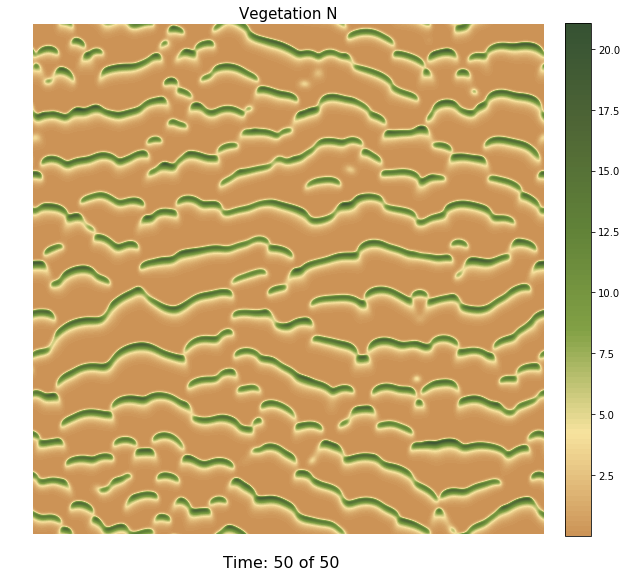

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

im=ax.imshow(Ns[:,:,NumPlots-1], cmap=VegMap, animated=True, interpolation='bilinear')
ax.set_title('Vegetation N', fontsize=15)
text=fig.suptitle("Time: %1.0f of %1.0f" % (EndTime, EndTime), x=0.47, y=0.12, fontsize=16);
ax.set_axis_off()

f=fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

### Making an animation

In [14]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    global Ns
    im.set_array(Ns[:,:,i])
    text.set_text("Time: %1.0f of %1.0f" % ((i+1)/NumPlots*EndTime, EndTime));
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = NumPlots, repeat=False, blit=True)

from IPython.display import HTML
HTML(ani.to_html5_video())

© Johan van de Koppel, NIOZ-Yerseke 2018